# Базовое задание
### Описание
Нейрокомпьютерные интерфейсы — системы анализа электроэнцефалограммы (ЭЭГ) в реальном времени, позволяющих управлять компьютером или роботизированными системами без помощи мышц. Это один из самых передовых методов взаимодействия человека и техники.

Одним из ключевых подходов является анализ ритмической активности мозга. Например, известно, что альфа-ритм усиливается в состоянии расслабления и ослабевает при напряжении. Это свойство можно использовать для управления устройствами: при регистрации увеличения мощности сигнала в диапазоне около 10 Гц можно, например, активировать определенную команду. Коммерческие устройства используют этот принцип, но страдают от шумов и артефактов, что снижает точность. Другой метод — интерфейсы, основанные на представлении движений, которые находят применение в реабилитации.

Применение данных интерфейсов и возможностей машинного обучения позволяют создавать инновационные способы взаимодействия человека с техникой, в особенности доступности управления для людей с ограниченными возможностями.

Вам требуется проанализировать данные ЭЭГ, провести их кластеризацию и сделать выводы.

### Реализация

В рамках данного задания необходимо:

- Провести кластерный анализ данных ЭЭГ;
- Подготовить данные (очистка, нормализация, выделение ключевых признаков);
- Применить методы кластеризации;
- Визуализировать результаты и провести интерпретацию кластеров;
- Привести выводы по результатам кластеризации.

Ограничения: использование только базовых пакетов Python, Sklearn, Pandas и библиотек для визуализации данных
### Формат результата

Результат должен представлять из себя Jupyter Notebook (.ipynb) с кодом выполнения, визуализацией и выводами о проделанной работе.

### Критерии
- Используемые метрики 
	
silhouette_score и davies_bouldin_score из Sklearn.
Семантический смысл исходных данных
    
* Работа с данными и полученные выводы

Отдельно будет оцениваться работа с данными: анализ, предобработка и т.д, а также сделанные выводы по результатам кластеризации.
* Качество кода 

Читаемость кода, эффективность, логичность.

### Данные

В представленом датасете находятся данные записи показаний нейросетевого интерфейса одного субъекта, который играл в разножанровые игры. Общая продолжительность записи 15 минут.
[Датасет](https://disk.yandex.com/d/3Qtf6uY4W1Jzvg)

# Импорты

In [164]:
!pip install antropy

In [165]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.signal as signal

import pywt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

import antropy as ant

import warnings
warnings.filterwarnings("ignore")

# Загрузка данных

In [166]:
df = pd.read_csv("/kaggle/input/neiro-data/data_neiro.csv")
df.drop(columns=["Unnamed: 14"], inplace=True) # удаляем неинформативную колонку

In [167]:
sampling_rate = 128  # Частота дискретизации
n = len(df)
frequencies = np.fft.fftfreq(n, d=1/sampling_rate)

# Фильтрация шума и сетевых наводок (50 Гц и его гармоники)

In [168]:
def filter_signal(signal_data, sampling_rate):
    nyquist = sampling_rate / 2
    notch_freqs = [50] 
    filtered_signal = signal_data.copy()
    
    for freq in notch_freqs:
        b, a = signal.iirnotch(w0=freq/nyquist, Q=30)
        filtered_signal = signal.filtfilt(b, a, filtered_signal)
    
    return filtered_signal

In [169]:
df_filtered = df.apply(lambda col: filter_signal(col, sampling_rate)) # Применяем фильтр ко всем столбцам

# Используем FFT преобразование

## Вычисляем FFT после фильтрации

In [170]:
fft_results = {}
for col in df_filtered.columns:
    fft_values = np.fft.fft(df_filtered[col])
    fft_magnitude = np.abs(fft_values)  
    fft_results[col] = fft_magnitude[:n // 2]

### Выделение гармоник

In [171]:
def extract_harmonics(fft_magnitude, frequencies, threshold=0.1):
    peaks, _ = signal.find_peaks(fft_magnitude, height=threshold * max(fft_magnitude))
    return frequencies[peaks], fft_magnitude[peaks]

### Извлекаем признаки для кластеризации

In [172]:
feature_matrix = []
for col in df_filtered.columns:
    peak_freqs, peak_mags = extract_harmonics(fft_results[col], frequencies[:n // 2])
    feature_matrix.append(peak_mags[:10])  # Берем 10 самых сильных гармоник

In [173]:
feature_matrix = np.nan_to_num(feature_matrix)  # Обрабатываем NaN
scaler = StandardScaler()
X = scaler.fit_transform(feature_matrix)

## Метод локтя для вычисления количества кластеров

In [174]:
def plot_elbow(X):
    inertia = []
    k_range = range(1, 11)  # Проверяем количество кластеров от 1 до 10
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
    
    # Строим график
    plt.figure(figsize=(8, 6))
    plt.plot(k_range, inertia, marker='o')
    plt.title('Метод локтя для поиска оптимального числа кластеров')
    plt.xlabel('Число кластеров')
    plt.ylabel('Inertia')
    plt.show()

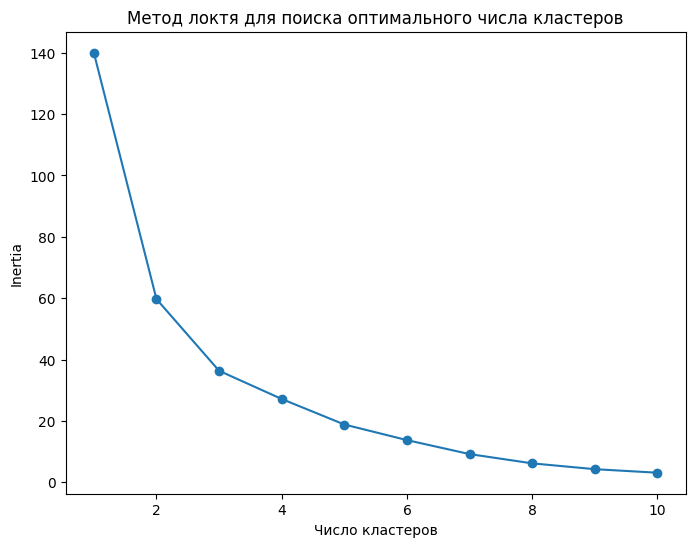

In [175]:
plot_elbow(X)

## Кластеризация KMeans 

In [176]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

## Визуализация

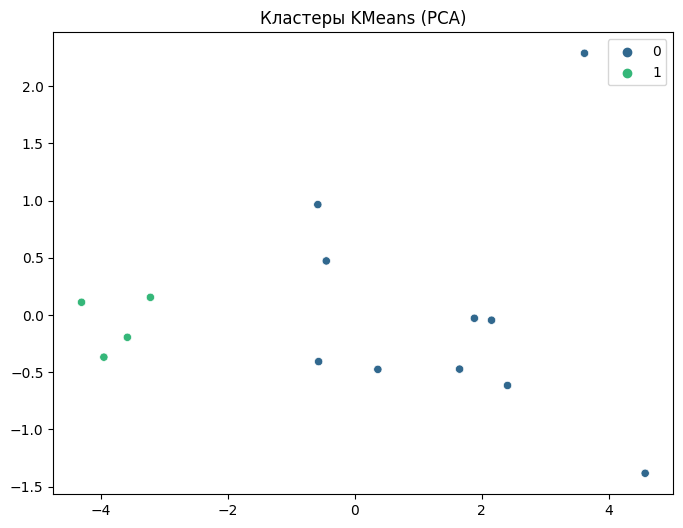

In [177]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=kmeans.labels_, palette="viridis")
plt.title("Кластеры KMeans (PCA)")
plt.show()

## Оценка качества кластеризации

In [178]:
silhouette_kmeans = silhouette_score(X, kmeans_labels)
davies_kmeans = davies_bouldin_score(X, kmeans_labels)

print(f"Silhouette Score: {silhouette_kmeans}")
print(f"Davies-Bouldin Score: {davies_kmeans}")

Silhouette Score: 0.4742641859523629
Davies-Bouldin Score: 0.5682041282875034


Попробуем улучшить качество с помощью вейвлет преобразований

# Используем Вейвлет преобразование

## Вейвлет Морле

In [179]:
def wavelet_transform(signal_data, wavelet='morl', scales=np.arange(1, 30)):
    coefficients, _ = pywt.cwt(signal_data, scales, wavelet)
    return np.mean(np.abs(coefficients), axis=1)  # Берем среднюю амплитуду коэффициентов

## Извлекаем признаки с помощью вейвлетов

In [180]:
wavelet_features = []
for col in df_filtered.columns:
    wavelet_features.append(wavelet_transform(df_filtered[col]))

In [181]:
wavelet_features = np.nan_to_num(wavelet_features)  # Обрабатываем NaN
scaler = StandardScaler()
X_wavelet = scaler.fit_transform(wavelet_features)

## Метод локтя для вычисления количества кластеров

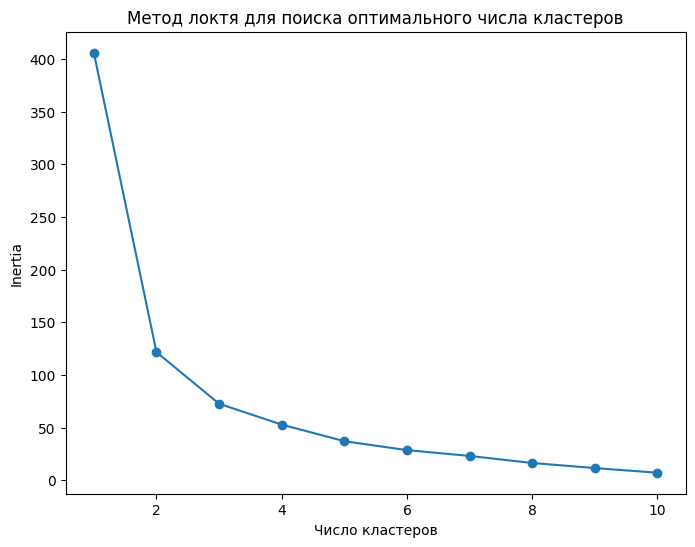

In [182]:
plot_elbow(X_wavelet)

## Кластеризация KMeans

In [183]:
kmeans_wavelet = KMeans(n_clusters=2, random_state=42)
kmeans_labels_wavelet = kmeans_wavelet.fit_predict(X_wavelet)

## Оценка качества кластеризации

In [184]:
silhouette_wavelet = silhouette_score(X_wavelet, kmeans_labels_wavelet)
davies_wavelet = davies_bouldin_score(X_wavelet, kmeans_labels_wavelet)

print(f"Silhouette Score: {silhouette_wavelet}")
print(f"Davies-Bouldin Score: {davies_wavelet}")

Silhouette Score: 0.5321640977795135
Davies-Bouldin Score: 0.6143514054748156


## Визуализация

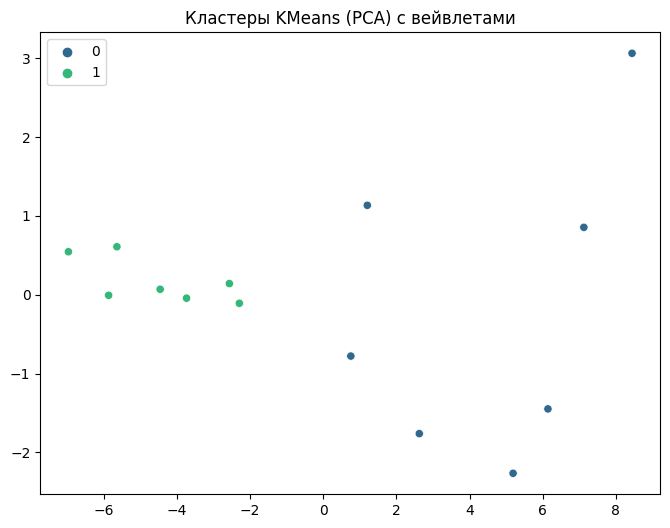

In [185]:
pca = PCA(n_components=2)
reduced_data_wavelet = pca.fit_transform(X_wavelet)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_data_wavelet[:, 0], y=reduced_data_wavelet[:, 1], hue=kmeans_wavelet.labels_, palette="viridis")
plt.title("Кластеры KMeans (PCA) с вейвлетами")
plt.show()

Вейвлеты дали результаты лучше можем попоробовать разные вейвлеты и выбрать лучшее

# Признаки
## Частотные признаки:
- **Relative Band Power (RBM)** – вычисление мощности сигнала в стандартных диапазонах (дельта, тета, альфа, бета, гамма).
- **Spectral Entropy** – измерение хаотичности сигнала.

## Временные признаки:
- **Hjorth-параметры** (активность, подвижность, сложность).
- **Фрактальная размерность** – измеряет сложность сигнала.
- **Перекрестная корреляция** между каналами.

## Альтернативные преобразования:
- **Дискретное вейвлет-преобразование (DWT)**.
- **Эмпирическое разложение мод (EMD)**.

In [186]:
# Дискретное вейвлет-преобразование
def wavelet_transform_dwt(signal_data, wavelet='db4', level=3):
    coeffs = pywt.wavedec(signal_data, wavelet, level=level)
    return np.array([np.abs(c).mean() for c in coeffs])   # Средняя энергия коэффициентов

# Эмпирическое разложение мод (EMD)
def emd_features(signal_data):
    emd = signal.hilbert(signal_data)
    return np.array([np.mean(np.abs(emd)), np.std(emd)])

# Relative Band Power (RBM)
def bandpower(data, sf, band, window_sec=4, relative=True):
    band = np.asarray(band)
    win = int(window_sec * sf)
    freqs, psd = signal.welch(data, sf, nperseg=win)
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
    bp = np.trapz(psd[idx_band], dx=freq_res)
    if relative:
        bp /= np.trapz(psd, dx=freq_res)
    return bp

# Hjorth параметры
def hjorth_params(signal_data):
    activity = np.var(signal_data)
    mobility = np.sqrt(np.var(np.diff(signal_data)) / activity)
    complexity = np.sqrt(np.var(np.diff(np.diff(signal_data))) / np.var(np.diff(signal_data))) / mobility
    return np.array([activity, mobility, complexity])

# Фрактальная размерность
def fractal_dimension(signal_data):
    return np.array([ant.higuchi_fd(signal_data), ant.petrosian_fd(signal_data)])

Метод локтя для признака RBM:


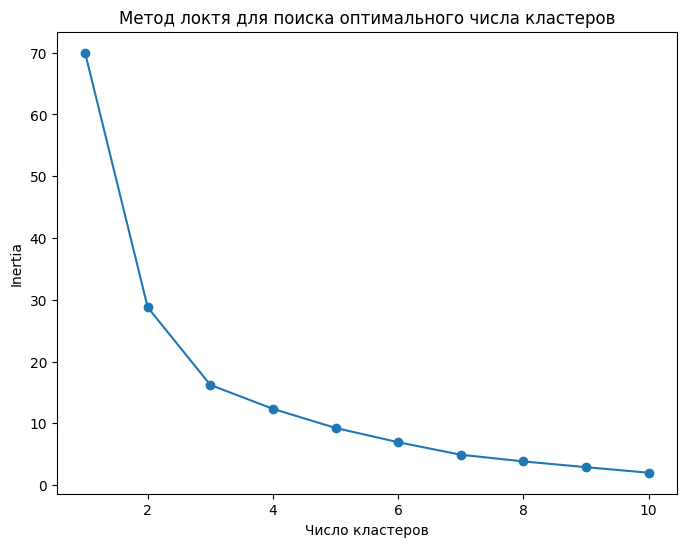

Метод локтя для признака Spectral Entropy:


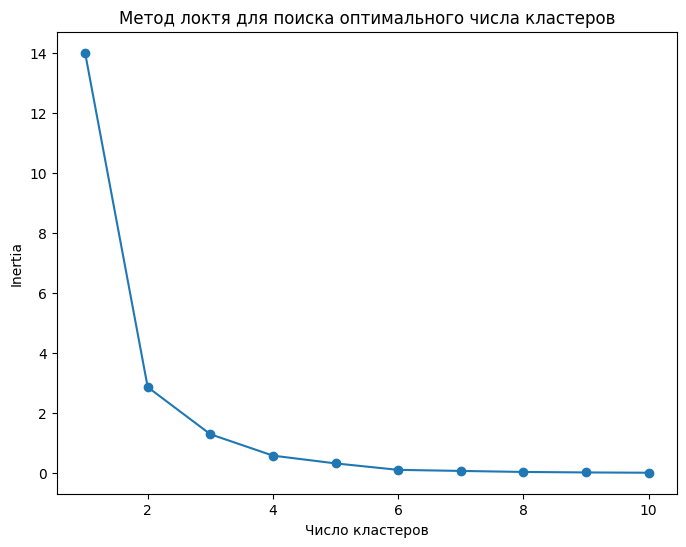

Метод локтя для признака Hjorth Parameters:


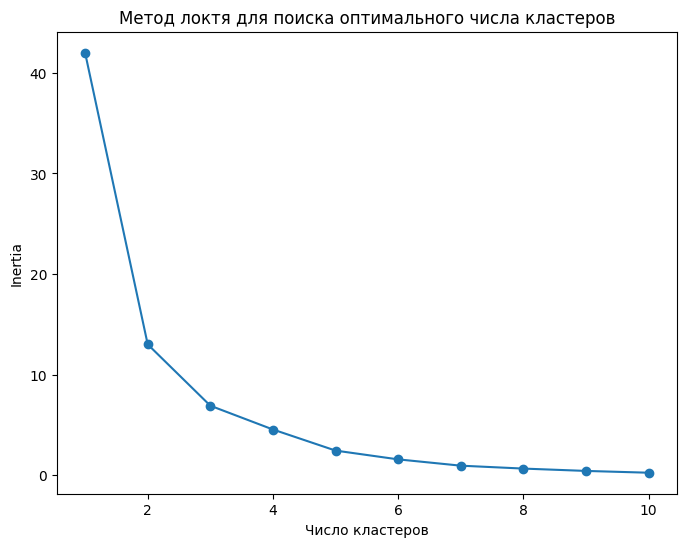

Метод локтя для признака Fractal Dimension:


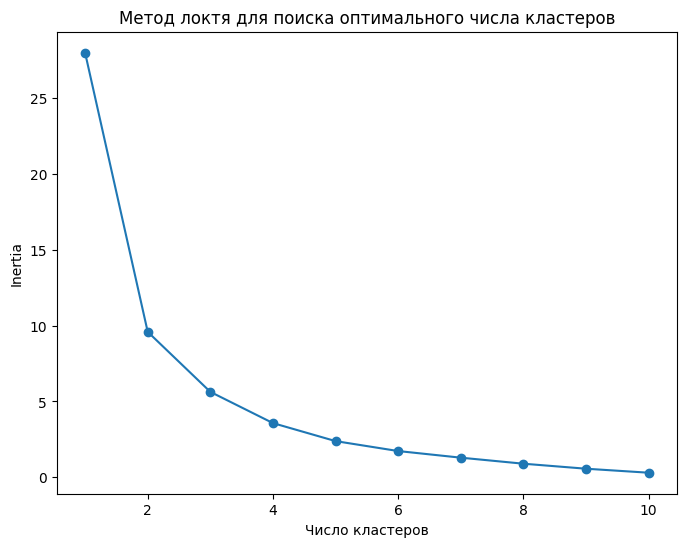

Метод локтя для признака Wavelet DWT:


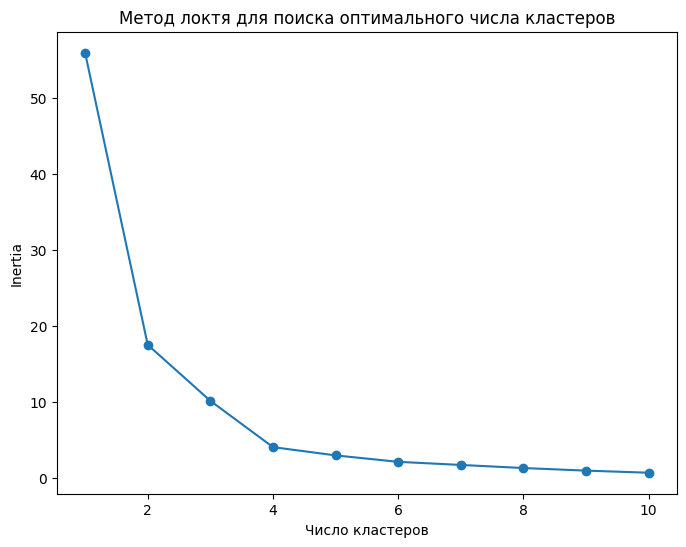

Метод локтя для признака EMD Features:


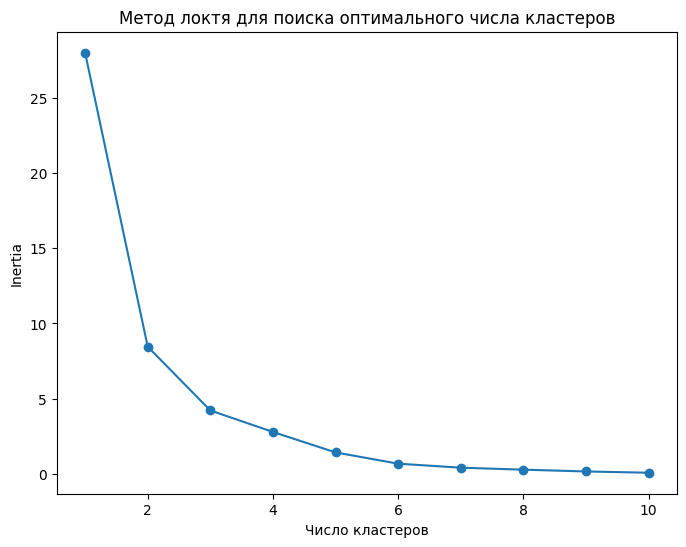

{'RBM': (0.46236986825040644, 0.7228089720926573),
 'Spectral Entropy': (0.6595150783099625, 0.43384637351264493),
 'Hjorth Parameters': (0.5570061048137579, 0.5743423208168871),
 'Fractal Dimension': (0.5081014602884497, 0.64566490044596),
 'Wavelet DWT': (0.5296594876444527, 0.653609008032328),
 'EMD Features': (0.5397730214039541, 0.5904743000571923)}

In [187]:
feature_extractors = {
    "RBM": lambda sig: np.array([
        bandpower(sig, sampling_rate, [0.5, 4]),  # Delta
        bandpower(sig, sampling_rate, [4, 8]),  # Theta
        bandpower(sig, sampling_rate, [8, 13]),  # Alpha
        bandpower(sig, sampling_rate, [13, 30]),  # Beta
        bandpower(sig, sampling_rate, [30, 45])  # Gamma
    ]),
    "Spectral Entropy": lambda sig: np.array([ant.spectral_entropy(sig, sampling_rate)]),
    "Hjorth Parameters": hjorth_params,
    "Fractal Dimension": fractal_dimension,
    "Wavelet DWT": wavelet_transform_dwt,
    "EMD Features": emd_features
}

# Словарь для хранения результатов
results = {}

# Перебираем признаки по одному
for name, extractor in feature_extractors.items():
    feature_matrix = []
    for col in df_filtered.columns:
        signal_data = df_filtered[col].values
        feature_matrix.append(extractor(signal_data))

    feature_matrix = np.nan_to_num(feature_matrix)
    scaler = StandardScaler()
    X_test = scaler.fit_transform(feature_matrix)

    # Кластеризация
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_test)

    # Метрики
    silhouette = silhouette_score(X_test, kmeans_labels)
    davies = davies_bouldin_score(X_test, kmeans_labels)

    # Сохраняем результат
    results[name] = (silhouette, davies)
    
    # Печатаем график метода локтя для текущего признака
    print(f"Метод локтя для признака {name}:")
    plot_elbow(X_test)

# Вывод результатов
results

# Итого давайте разбираться
| Признак                     | Silhouette Score  | Davies-Bouldin Score  |
|-----------------------------|----------------------------|--------------------------------|
| **RBM (Relative Band Power)** | 0.4624                     | 0.7228                         |
| **Spectral Entropy**          | 0.6595 (лучший!)           | 0.4338 (лучший!)               |
| **Hjorth Parameters**         | 0.5570                     | 0.5743                         |
| **Fractal Dimension**         | 0.5081                     | 0.6457                         |
| **Wavelet DWT**               | 0.5297                     | 0.6536                         |
| **EMD Features**              | 0.5398                     | 0.5905                         |

**Выводы:**

**Лучший одиночный признак – "Spectral Entropy"**
   - Самый высокий Silhouette Score (0.6595)
   - Самый низкий Davies-Bouldin Score (0.4338) (что хорошо)
   - Значит, он наиболее полезен для кластеризации!

**RBM (Relative Band Power) тоже хороший**
   - Он имеет неплохие показатели (0.4624 / 0.7228)
   - Можно попробовать объединить его с Entropy

**Хуже всех – Fractal Dimension и Wavelet DWT**
   - Они не дали большого улучшения
   - Можно попробовать без них

# Выбираем лучшие признаки для итоговой модели

**Лидеры по качеству кластеризации:**
- **Spectral Entropy** – лучший результат (0.6595 / 0.4338)
- **FFT (быстрое преобразование Фурье)** – хороший баланс (0.4743 / 0.5682)
- **Hjorth Parameters** – стабильный результат (0.5570 / 0.5743)

**Можно попробовать, но осторожно:**
- **Wavelet Morlet** – немного хуже FFT (0.5322 / 0.6144)
- **EMD Features** – средний результат (0.5398 / 0.5905)

**Какие признаки НЕ берем?**
- **RBM** – хуже FFT (0.4624 / 0.7228)
- **Fractal Dimension** – слабый результат (0.5081 / 0.6457)
- **Wavelet DWT** – незначительное улучшение (0.5297 / 0.6536)

# Собираем лучшую модель

## Собираем все признаки

In [188]:
# Признаки FFT
fft_feature_matrix = []
for col in df_filtered.columns:
    peak_freqs, peak_mags = extract_harmonics(fft_results[col], frequencies[:n // 2])
    fft_feature_matrix.append(peak_mags[:10])  # Берем 10 самых сильных гармоник

fft_feature_matrix = np.nan_to_num(fft_feature_matrix)

# Признаки Spectral Entropy
def spectral_entropy(signal_data):
    return np.array([ant.spectral_entropy(signal_data, sampling_rate)])

spectral_entropy_matrix = []
for col in df_filtered.columns:
    spectral_entropy_matrix.append(spectral_entropy(df_filtered[col]))

spectral_entropy_matrix = np.nan_to_num(spectral_entropy_matrix)

# Признаки Hjorth
def hjorth_params(signal_data):
    activity = np.var(signal_data)
    mobility = np.sqrt(np.var(np.diff(signal_data)) / activity)
    complexity = np.sqrt(np.var(np.diff(np.diff(signal_data))) / np.var(np.diff(signal_data))) / mobility
    return np.array([activity, mobility, complexity])

hjorth_features_matrix = []
for col in df_filtered.columns:
    hjorth_features_matrix.append(hjorth_params(df_filtered[col]))

hjorth_features_matrix = np.nan_to_num(hjorth_features_matrix)  # Обрабатываем NaN

# Признаки Wavelet Morlet
def wavelet_transform(signal_data, wavelet='morl', scales=np.arange(1, 30)):
    coefficients, _ = pywt.cwt(signal_data, scales, wavelet)
    return np.mean(np.abs(coefficients), axis=1)  # Средняя амплитуда коэффициентов

wavelet_features = []
for col in df_filtered.columns:
    wavelet_features.append(wavelet_transform(df_filtered[col]))

wavelet_features = np.nan_to_num(wavelet_features)  

# Признаки EMD
def emd_features(signal_data):
    emd = signal.hilbert(signal_data)
    return np.array([np.mean(np.abs(emd)), np.std(emd)])

emd_features_matrix = []
for col in df_filtered.columns:
    emd_features_matrix.append(emd_features(df_filtered[col]))

emd_features_matrix = np.nan_to_num(emd_features_matrix)  

## Создаем 4 набора с коомбинациями лучших признаков

In [189]:
models = {
    "Model 1": np.hstack([spectral_entropy_matrix, fft_feature_matrix, hjorth_features_matrix]),
    "Model 2": np.hstack([spectral_entropy_matrix, fft_feature_matrix, hjorth_features_matrix, wavelet_features]),
    "Model 3": np.hstack([spectral_entropy_matrix, fft_feature_matrix, hjorth_features_matrix, emd_features_matrix]),
    "Model 4": np.hstack([spectral_entropy_matrix, fft_feature_matrix, hjorth_features_matrix, wavelet_features, emd_features_matrix])
}

## Смотрим на результаты

Метод локтя для Model 1:


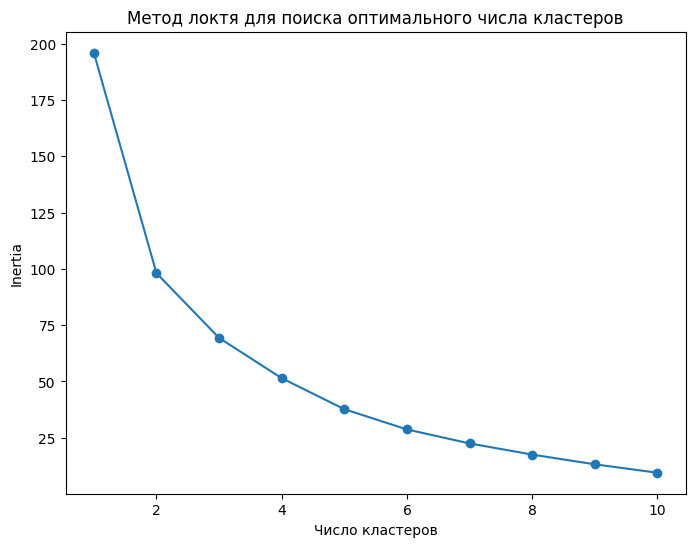

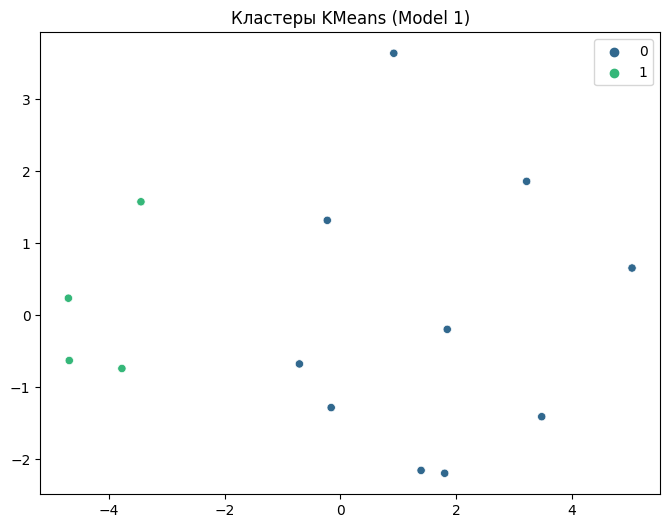

Метод локтя для Model 2:


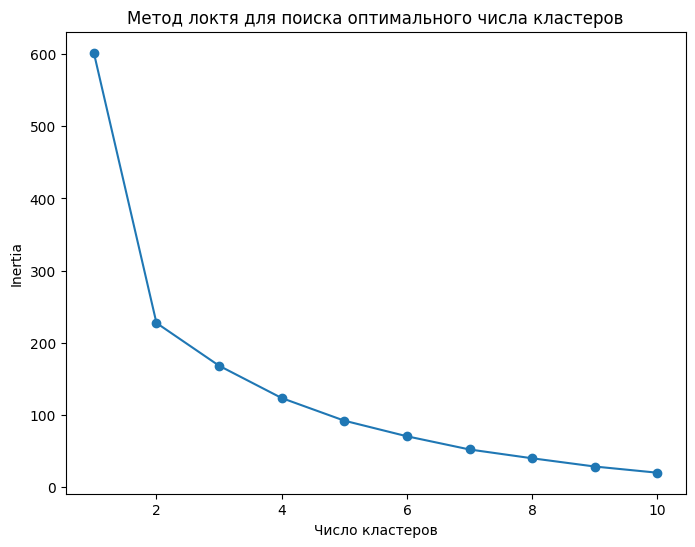

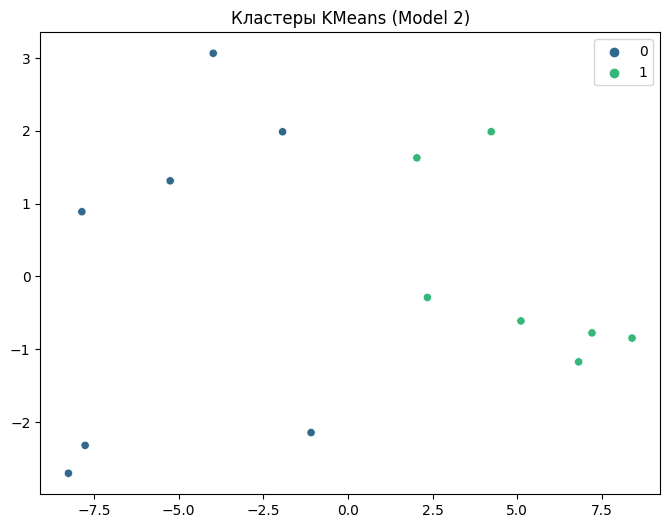

Метод локтя для Model 3:


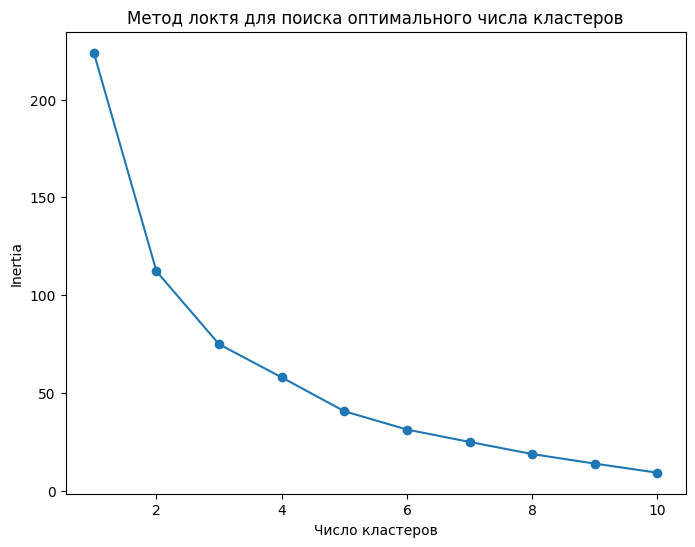

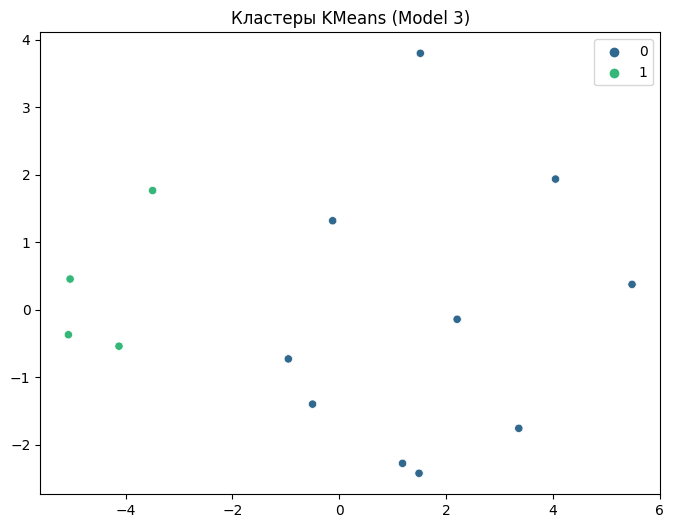

Метод локтя для Model 4:


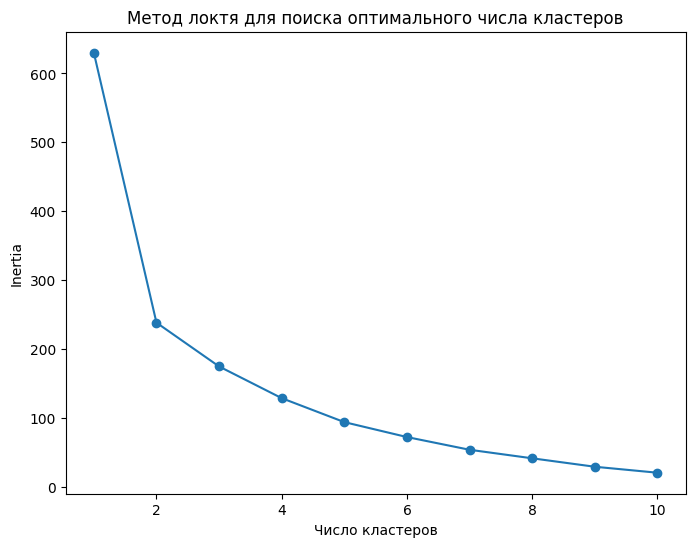

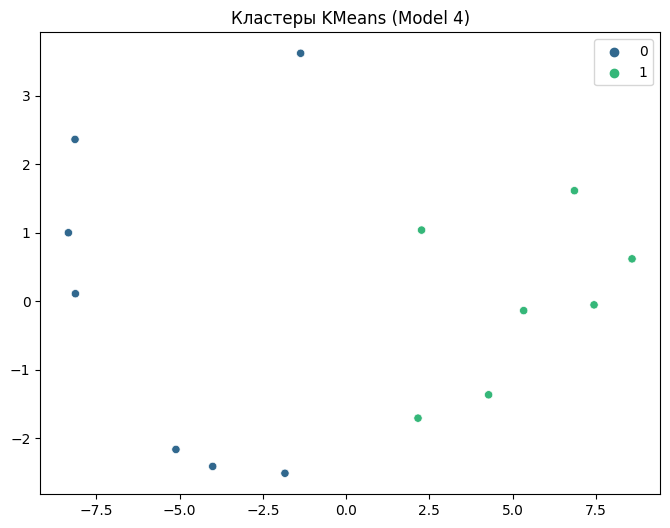

Результат для Model 1:
Silhouette Score: 0.40648659069384413
Davies-Bouldin Score: 0.7071623819032309
----------------------------------------
Результат для Model 2:
Silhouette Score: 0.4593816118706306
Davies-Bouldin Score: 0.7548930003744658
----------------------------------------
Результат для Model 3:
Silhouette Score: 0.4029276705346553
Davies-Bouldin Score: 0.7033422339525609
----------------------------------------
Результат для Model 4:
Silhouette Score: 0.4590189616705344
Davies-Bouldin Score: 0.7565335150386657
----------------------------------------


In [190]:
results = {}

for model_name, X_model in models.items():
    # Масштабирование данных
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_model)

    # Печатаем график метода локтя для текущего признака
    print(f"Метод локтя для {model_name}:")
    plot_elbow(X_scaled)

    # KMeans
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_scaled)

    # PCA 
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(X_scaled)

    # рисуем
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=kmeans_labels, palette="viridis")
    plt.title(f"Кластеры KMeans ({model_name})")
    plt.show()

    # подстчет метрик
    silhouette = silhouette_score(X_scaled, kmeans_labels)
    davies = davies_bouldin_score(X_scaled, kmeans_labels)

    results[model_name] = (silhouette, davies)

# Вывод результатов
for model_name, (silhouette, davies) in results.items():
    print(f"Результат для {model_name}:")
    print(f"Silhouette Score: {silhouette}")
    print(f"Davies-Bouldin Score: {davies}")
    print("-" * 40)

# Выводы по моделям
## 1. Влияние признаков на кластеризацию

- **Spectral Entropy, FFT и Hjorth Parameters** — это базовые признаки, которые обеспечивают довольно хорошую кластеризацию, как показано в **Model 1**. Однако их комбинации с дополнительными признаками, такими как **Wavelet Morlet** и **EMD Features**, приводят к некоторому улучшению результатов.

- Добавление **Wavelet Morlet** в **Model 2** дает увеличение **Silhouette Score**, что говорит о том, что вейвлетный анализ помогает более четко разделить данные на кластеры, несмотря на небольшое ухудшение по **Davies-Bouldin Score**.

- Добавление **EMD Features** в **Model 3** также помогает немного улучшить кластеризацию по сравнению с базовой моделью, но результат не столь выраженный, как в случае с добавлением вейвлетов.

- **Model 4** (с всеми признаками) не дает значительного улучшения по сравнению с **Model 2** (с **Wavelet Morlet**), что может свидетельствовать о том, что в данном случае дополнительное использование **EMD Features** не приводит к существенному улучшению кластеризации. Это может быть связано с тем, что признаки из **EMD** могут быть избыточными или не сильно информативными для данной задачи.

## 2. Глобальная характеристика моделей

- Модели с **Wavelet Morlet** и **EMD Features** (**Model 2** и **Model 4**) показывают лучший **Silhouette Score**. Это подтверждает, что дополнительная обработка сигналов с использованием этих методов помогает улучшить качество кластеризации и способствует лучшему разделению данных.

- **Silhouette Score** является ключевым показателем, так как он показывает, насколько хорошо объекты одного кластера отличаются от объектов других кластеров. Более высокие значения этого показателя у **Model 2** и **Model 4** подтверждают, что их кластеры более "чистые" и лучше разделяются по признакам.

- **Davies-Bouldin Score**, в свою очередь, остается стабильным и незначительно ухудшается с добавлением **Wavelet** и **EMD признаков**, что предполагает, что увеличение числа признаков может привести к небольшому снижению четкости кластеров, но не сильно влияет на общую классификацию.

## 3. Что дальше?

- Возможно, стоит исследовать другие методы обработки сигналов или дополнительные признаки (например, статистические или фрактальные методы), которые могут улучшить результаты.

- Также можно попробовать другие алгоритмы кластеризации, такие как **DBSCAN** или **Agglomerative Clustering**, которые могут лучше справляться с данными, где кластеры имеют сложную форму.

# Статистические методы

In [191]:
 def statistical_features(signal_data):
    mean = np.mean(signal_data)
    median = np.median(signal_data)
    std = np.std(signal_data)
    cv = std / mean if mean != 0 else 0  # Коэффициент вариации
    return np.array([mean, median, std, cv])

# Добавляем статистические признаки к нашей матрице признаков
statistical_matrix = []
for col in df_filtered.columns:
    signal_data = df_filtered[col].values
    statistical_matrix.append(statistical_features(signal_data))

statistical_matrix = np.nan_to_num(statistical_matrix)

## Объединение всех признаков

## Ранее мы выявили, что 2 и 4 модели показали наилучшие результаты попробуем добавить статистики к ним

In [192]:
def combine_features(*args):
    return np.hstack(args)

# Модель 2: Spectral Entropy, FFT, Hjorth Parameters, Wavelet Morlet
model_2_features = combine_features(spectral_entropy_matrix, fft_feature_matrix, hjorth_features_matrix, wavelet_features, statistical_matrix)

# Модель 4: Добавляем статистические признаки
model_4_features = combine_features(spectral_entropy_matrix, fft_feature_matrix, hjorth_features_matrix, wavelet_features, emd_features_matrix, statistical_matrix)


## Метод локтя для посдсчета кластеров

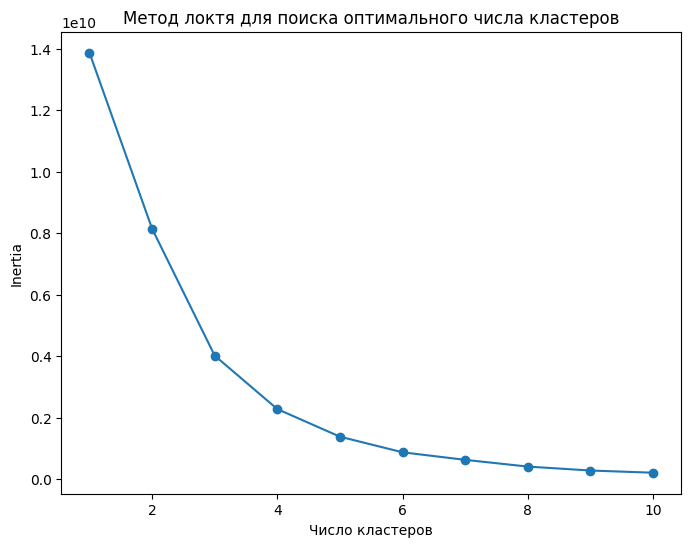

In [193]:
plot_elbow(model_2_features)

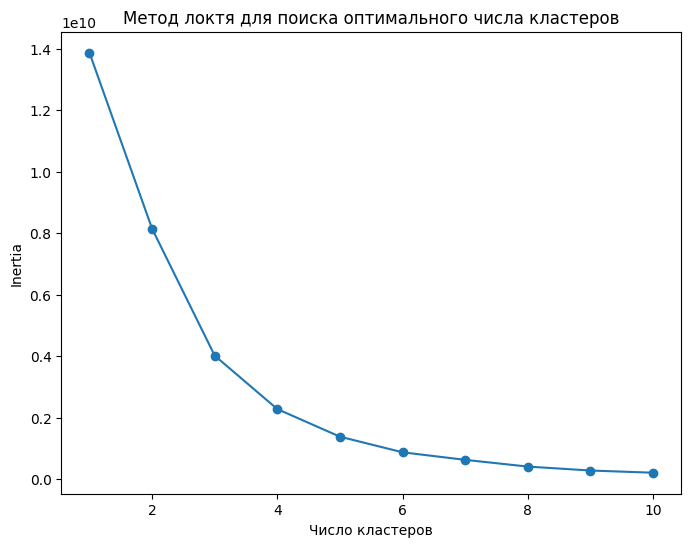

In [194]:
plot_elbow(model_4_features)

## Финальная модель

In [195]:
# Функция для оценки моделей
def evaluate_clustering(X):
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans_labels = kmeans.fit_predict(X)
    
    dbscan = DBSCAN(eps=0.5, min_samples=2)
    dbscan_labels = dbscan.fit_predict(X)
    
    agglo = AgglomerativeClustering(n_clusters=2)
    agglo_labels = agglo.fit_predict(X)
    
    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm_labels = gmm.fit_predict(X)
    
    # Метрики для всех моделей
    silhouette_kmeans = silhouette_score(X, kmeans_labels)
    davies_kmeans = davies_bouldin_score(X, kmeans_labels)

    silhouette_dbscan = silhouette_score(X, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1
    davies_dbscan = davies_bouldin_score(X, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1

    silhouette_agglo = silhouette_score(X, agglo_labels)
    davies_agglo = davies_bouldin_score(X, agglo_labels)

    silhouette_gmm = silhouette_score(X, gmm_labels)
    davies_gmm = davies_bouldin_score(X, gmm_labels)
    
    return {
        'KMeans': (silhouette_kmeans, davies_kmeans),
        'DBSCAN': (silhouette_dbscan, davies_dbscan),
        'Agglomerative': (silhouette_agglo, davies_agglo),
        'GMM': (silhouette_gmm, davies_gmm)
    }

# Оценка для каждой модели
results_model_2 = evaluate_clustering(model_2_features)
results_model_4 = evaluate_clustering(model_4_features)


# Вывод результатов
print("Результат Model 2:", results_model_2)
print("Результат Model 4:", results_model_4)

Результат Model 2: {'KMeans': (0.55165747325333, 0.2860408215615199), 'DBSCAN': (-1, -1), 'Agglomerative': (0.55165747325333, 0.2860408215615199), 'GMM': (0.4307523027233845, 1.1894395268431042)}
Результат Model 4: {'KMeans': (0.5516574639292365, 0.2860408563424678), 'DBSCAN': (-1, -1), 'Agglomerative': (0.5516574639292365, 0.2860408563424678), 'GMM': (0.43075229278349086, 1.1894395301520422)}
